## Set up the environment and import required libraries

***Done by Juin Tan***

In [ ]:
# Install packages
!pip install tensorflow tensorflow-addons
!pip install fpdf

# Import required libraries
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import time
import os
import datetime
import json

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, mean_squared_error, r2_score, roc_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   RobustScaler, StandardScaler)
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling1D, GlobalAveragePooling2D,
                                     MaxPooling2D, Input, Reshape, Activation, Concatenate, Add, BatchNormalization)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.python.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K

import cv2
from PIL import Image
from skimage import exposure
from fpdf import FPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 27.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=d7ca85963d4da69cd62c5aba27a5694cd9e8f8de1d5ba3fa0916c8a199cf03ca
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [ ]:
!pip show tensorflow
!pip show tensorflow-addons
!pip show numpy
!pip show pandas
!pip show matplotlib
!pip show seaborn
!pip show scikit-learn
!pip show opencv-python
!pip show Pillow
!pip show scikit-image
!python --version

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/MyDrive/COMP4211_Project"
%ls

Mounted at /content/drive
/content/drive/MyDrive/COMP4211_Project
 Brain_Tumor_Prediction_Report_Successful.pdf    'COMP4211 Project Proposal.gdoc'
 Brain_Tumor_Prediction_Report_Unsuccessful.pdf  'COMP4211 Proposal.gdoc'
 Classification_Dataset/                         'COMP4211 Report Draft.gdoc'
 ClassificationModel_Weights/                    'COMP4211 Report.gdoc'
 cnn_model.png                                   'Copy of COMP4211 Report.gdoc'
'COMP4211 Personal Draft Project.gdoc'           'Copy of COMP4211 Report [LATEST].gdoc'
 COMP4211_Project_Code.ipynb                      Generated_Report/
'COMP4211 Project Draft.gdoc'                     model.png
'COMP4211 Project Proposal Draft.gdoc'


In [ ]:
tf.device('/GPU:0')

## Important Constants / Hyperparameters

***Done by Juin Tan***

In [ ]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
IMG_HEIGHT, IMG_WIDTH = 224, 224
DATASET_PATH = "/content/drive/MyDrive/COMP4211_Project/Classification_Dataset"

In [ ]:
image_labels = ['Glioma', 'Pituitary', 'Meningioma', 'Healthy']
num_classes = len(image_labels)  # Number of classes

## Load and Visualize the Dataset

***Done by Juin Tan***

In [ ]:
def load_data(base_path):
    images = []
    labels = []

    for label, category in enumerate(image_labels):
        category_path = os.path.join(base_path, category)

        count = 0

        for img_file in os.listdir(category_path):
            # [DEVELOPMENT]
            # if count == 10:
            #     break

            img_path = os.path.join(category_path, img_file)

            # Load image
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Resize to fixed size
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
            labels.append(label)

            count += 1

    return np.array(images), np.array(labels)

loaded_X_test_classification, loaded_Y_test_classification = load_data(os.path.join(DATASET_PATH, "Testing"))
loaded_X_train_classification, loaded_Y_train_classification = load_data(os.path.join(DATASET_PATH, "Training"))

In [ ]:
# Data conversion for testing dataset
X_test_classification = loaded_X_test_classification.astype(np.float32)
Y_test_classification = loaded_Y_test_classification.astype(np.int32)

# Data conversion for training dataset
X_train_classification = loaded_X_train_classification.astype(np.float32)
Y_train_classification = loaded_Y_train_classification.astype(np.int32)

In [ ]:
print("Testing data shape:", loaded_X_test_classification.shape, loaded_Y_test_classification.shape)
print("Training data shape:", loaded_X_train_classification.shape, loaded_Y_train_classification.shape)
print()
print("Testing data shape:", X_test_classification.shape, Y_test_classification.shape)
print("Training data shape:", X_train_classification.shape, Y_train_classification.shape)

# Testing data shape: (1311, 224, 224, 3) (1311,)
# Training data shape: (5792, 224, 224, 3) (5792,)

Testing data shape: (1311, 224, 224, 3) (1311,)
Training data shape: (5792, 224, 224, 3) (5792,)

Testing data shape: (1311, 224, 224, 3) (1311,)
Training data shape: (5792, 224, 224, 3) (5792,)


total_counts: [1631. 1757. 1715. 2000.]


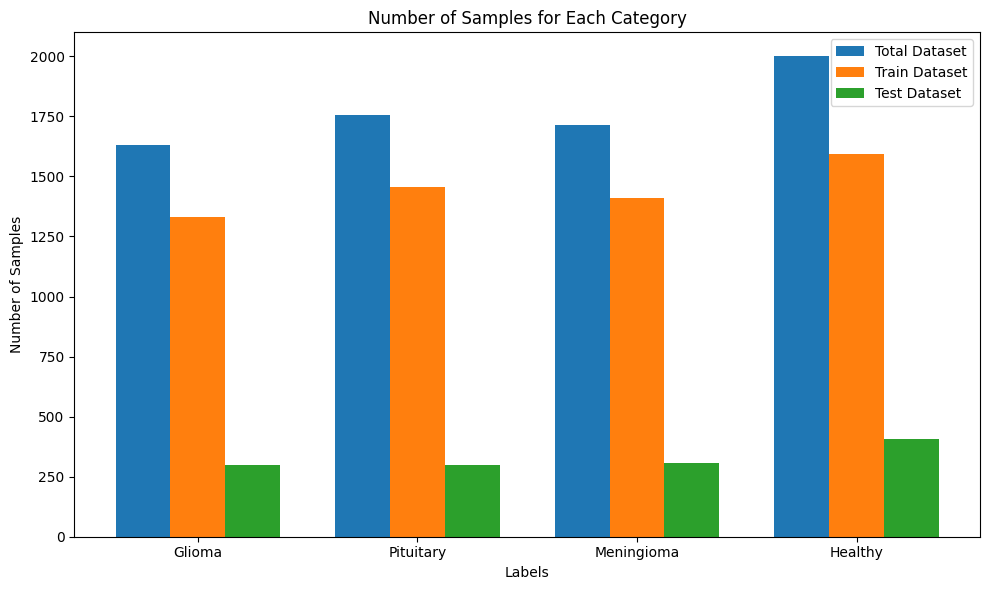

In [ ]:
def visualize_classification_dataset(Y_test_classification, Y_train_classification, num_classes):
    test_counts = np.zeros(num_classes)
    train_counts = np.zeros(num_classes)
    total_counts = np.zeros(num_classes)

    # Count the number of samples of each category in the testing dataset
    for i in range(num_classes):
        test_counts[i] = np.sum(Y_test_classification == i)

    # Count the number of samples of each category in the training dataset
    for i in range(num_classes):
        train_counts[i] = np.sum(Y_train_classification == i)

    test_counts = test_counts.astype(int)
    train_counts = train_counts.astype(int)

    # Count the number of samples of each category in the overall dataset
    for i in range(num_classes):
        total_counts[i] = test_counts[i] + train_counts[i]

    print(f"total_counts: {total_counts}")

    # Set the x-axis positions for the bars
    x = np.arange(len(image_labels))
    bar_width = 0.25

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the train and test data
    ax.bar(x - bar_width, total_counts, bar_width, label="Total Dataset")
    ax.bar(x, train_counts, bar_width, label="Train Dataset")
    ax.bar(x + bar_width, test_counts, bar_width, label="Test Dataset")

    # Add labels and title
    ax.set_xlabel('Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Number of Samples for Each Category')
    ax.set_xticks(x)
    ax.set_xticklabels(image_labels)
    ax.legend()

    # Adjust the layout
    plt.tight_layout()

    # Display the plot
    plt.show()

visualize_classification_dataset(Y_test_classification, Y_train_classification, num_classes)

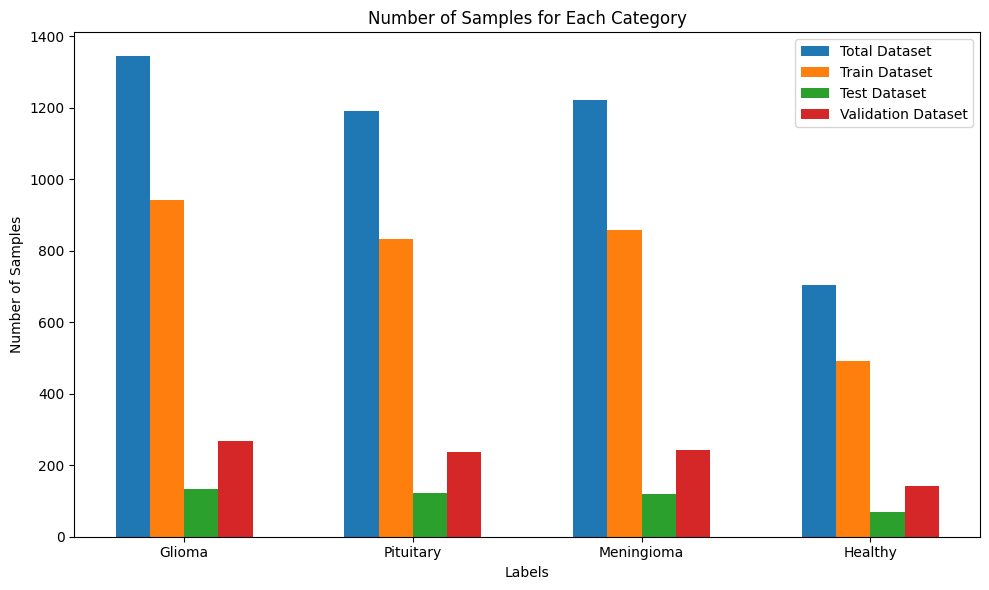

In [ ]:
def visualize_segmentation_dataset():
    train_counts = [943, 834, 859, 491]
    test_counts = [133, 121, 120, 70]
    val_counts = [268, 237, 244, 142]
    total_counts = [1344, 1192, 1223, 703]

    # Set the x-axis positions for the bars
    x = np.arange(len(image_labels))
    bar_width = 0.15

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the train and test data
    ax.bar(x - 1.5 * bar_width, total_counts, bar_width, label="Total Dataset")
    ax.bar(x - 0.5 * bar_width, train_counts, bar_width, label="Train Dataset")
    ax.bar(x + 0.5 * bar_width, test_counts, bar_width, label="Test Dataset")
    ax.bar(x + 1.5 * bar_width, val_counts, bar_width, label="Validation Dataset")

    # Add labels and title
    ax.set_xlabel('Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Number of Samples for Each Category')
    ax.set_xticks(x)
    ax.set_xticklabels(image_labels)
    ax.legend()

    # Adjust the layout
    plt.tight_layout()

    # Display the plot
    plt.show()

visualize_segmentation_dataset()

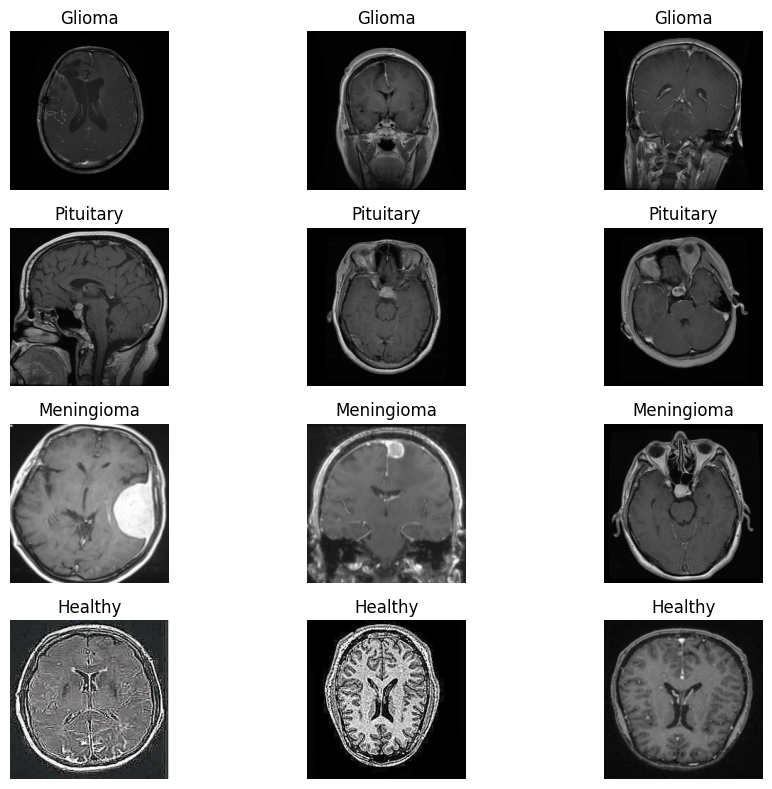

In [ ]:
def group_images(images, labels, image_labels, n_samples_per_class):
    images_group = {label: [] for label in image_labels}
    class_count = {label: 0 for label in image_labels}

    for image, label in zip(images, labels):
        label_idx = int(label)

        if class_count[image_labels[label_idx]] < n_samples_per_class:
            images_group[image_labels[label_idx]].append(image)
            class_count[image_labels[label_idx]] += 1

        # Stop if we've displayed enough samples for each class
        if all(count >= n_samples_per_class for count in class_count.values()):
            break

    return images_group

# Function to display grouped images
def display_grouped_images(images_group, image_labels):
    num_classes = len(image_labels)
    n_samples_per_class = len(next(iter(images_group.values())))  # Get sample count for one class

    plt.figure(figsize=(10, num_classes * 2))  # Adjust height based on the number of classes

    for i, label in enumerate(image_labels):
        for j in range(n_samples_per_class):
            if j < len(images_group[label]):
                plt.subplot(num_classes, n_samples_per_class, i * n_samples_per_class + j + 1)
                plt.imshow(images_group[label][j])  # Display the image
                plt.axis('off')
                plt.title(label)

    plt.tight_layout()
    plt.show()

# Group images and display
n_samples_per_class = 3
images_group = group_images(X_train_classification, Y_train_classification, image_labels, n_samples_per_class)
display_grouped_images(images_group, image_labels)

## Machine Learning Task 1: Brain MRI Classification Model

***Done by Juin Tan***

### Preprocess the classification dataset

***Done by Juin Tan***

In [ ]:
# Preprocess images by performing different image processing techniques

# Function to perform noise reduction using Gaussian Blur
def noise_reduction(image):
    # Rescale to [0, 255] for processing
    image_255 = (image * 255).astype(np.uint8)
    return cv2.GaussianBlur(image_255, (5, 5), 0) / 255.0  # Normalize back to [0, 1]

# Function to perform contrast enhancement using Histogram Equalization
def contrast_enhancement(image):
    # Rescale to [0, 255] for processing
    image_255 = (image * 255).astype(np.uint8)

    # Convert to YUV color space
    yuv_image = cv2.cvtColor(image_255, cv2.COLOR_BGR2YUV)

    # Apply histogram equalization to the Y channel
    yuv_image[:,:,0] = cv2.equalizeHist(yuv_image[:,:,0])

    # Convert back to BGR color space
    enhanced_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

    # Normalize back to [0, 1]
    return enhanced_image / 255.0

# Function to perform stack edge detection
def stack_edge_detection(image):
    # Convert the input image to 8-bit unsigned integer format if necessary
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Scale and convert to uint8

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Canny edge detection
    canny_edges = cv2.Canny(blurred_image, threshold1=50, threshold2=300)

    # Sobel edge detection
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in x
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in y
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)  # Combined magnitude
    sobel_magnitude = cv2.normalize(sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Normalize to [0, 255]
    sobel_magnitude = sobel_magnitude.astype(np.uint8)  # Convert to uint8

    # Stack the edges with the original grayscale image
    stacked_image = np.stack((gray_image, canny_edges, sobel_magnitude), axis=-1)

    return stacked_image

# Initialize lists to store processed images
X_train_classification_noise_reduction = []
X_train_classification_contrast_enhancement = []
X_train_classification_stacked_edges = []

# Process each image in X_train_classification
for image in X_train_classification:
    # Perform noise reduction
    denoised_image = noise_reduction(image)
    X_train_classification_noise_reduction.append(denoised_image)

    # Perform contrast enhancement
    enhanced_image = contrast_enhancement(image)
    X_train_classification_contrast_enhancement.append(enhanced_image)

    # Perform stack edge
    stacked_image = stack_edge_detection(image)
    X_train_classification_stacked_edges.append(stacked_image)

# Convert lists to numpy arrays for further processing
X_train_classification_noise_reduction = np.array(X_train_classification_noise_reduction)
X_train_classification_contrast_enhancement = np.array(X_train_classification_contrast_enhancement)
X_train_classification_stacked_edges = np.array(X_train_classification_stacked_edges)

# Print shapes of the processed arrays
print(f"X_train_classification shape: {X_train_classification.shape}")
print(f"X_train_classification_noise_reduction shape: {X_train_classification_noise_reduction.shape}")
print(f"X_train_classification_contrast_enhancement shape: {X_train_classification_contrast_enhancement.shape}")
print(f"X_train_classification_stacked_edges shape: {X_train_classification_stacked_edges.shape}")

X_train_classification shape: (5792, 224, 224, 3)
X_train_classification_noise_reduction shape: (5792, 224, 224, 3)
X_train_classification_contrast_enhancement shape: (5792, 224, 224, 3)
X_train_classification_stacked_edges shape: (5792, 224, 224, 3)


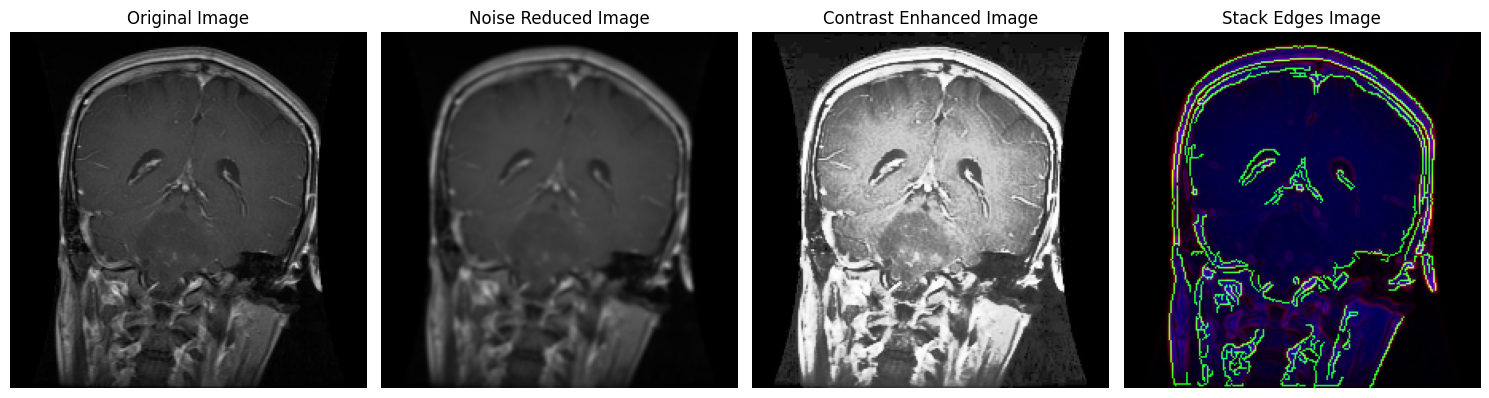

In [ ]:
# Show the preprocessed images at different index

# Function to convert images for display
def convert_for_display(image):
    # Check if the image is in float format and convert it to uint8
    if image.dtype == np.float64 or image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
    return image

def display_preprocessed_images(original, denoised, enhanced, stacked, index):
    # Set up the figure and axes for displaying images
    plt.figure(figsize=(15, 5))

    # Convert and display original image
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(convert_for_display(original), cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Convert and display denoised image
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(convert_for_display(denoised), cv2.COLOR_BGR2RGB))
    plt.title('Noise Reduced Image')
    plt.axis('off')

    # Convert and display enhanced image
    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(convert_for_display(enhanced), cv2.COLOR_BGR2RGB))
    plt.title('Contrast Enhanced Image')
    plt.axis('off')

    # Convert and display stacked image
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(convert_for_display(stacked), cv2.COLOR_BGR2RGB))
    plt.title('Stack Edges Image')
    plt.axis('off')

    # Display the images
    plt.tight_layout()
    plt.show()

# Choose an index to display images for
index = 2  # Change this to display different images

# Display preprocessed images for the selected index
display_preprocessed_images(X_train_classification[index],
                            X_train_classification_noise_reduction[index],
                            X_train_classification_contrast_enhancement[index],
                            X_train_classification_stacked_edges[index],
                            index)

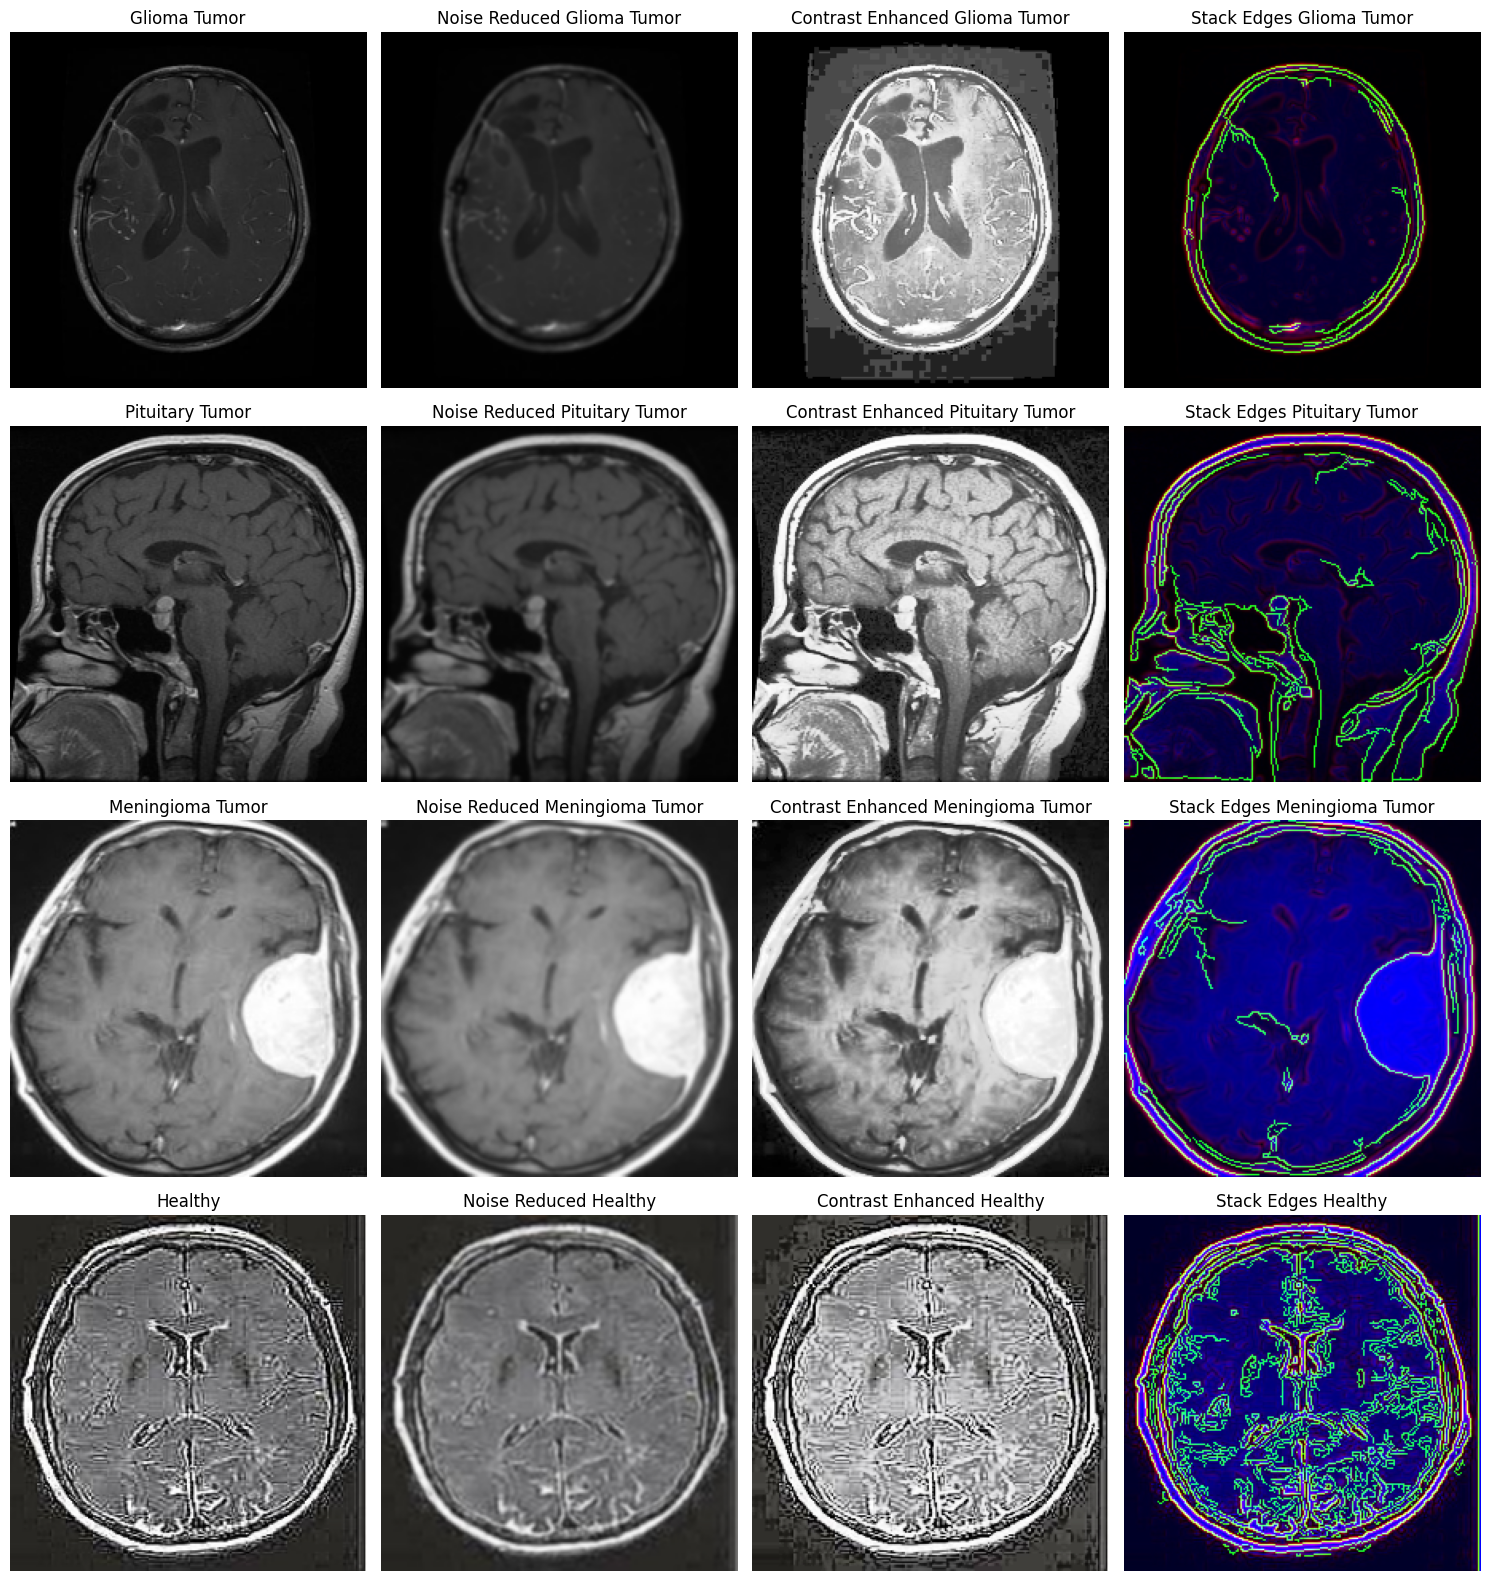

In [ ]:
# Show the preprocessed images using different techniques for each category

# Function to group images by category
def group_images_by_category(original_images, noise_reduced_images, contrast_enhanced_images, edge_stacked_images, labels, image_labels):
    images_group = {label: [] for label in image_labels}
    class_count = {label: 0 for label in image_labels}

    for image_index, (image, label) in enumerate(zip(original_images, labels)):
        label_idx = int(label)
        category_label = image_labels[label_idx]

        if class_count[category_label] == 0:
            images_group[category_label].append(image)  # Original image
            images_group[category_label].append(noise_reduced_images[image_index])  # Noise reduced image
            images_group[category_label].append(contrast_enhanced_images[image_index])  # Contrast enhanced image
            images_group[category_label].append(edge_stacked_images[image_index])  # Edge stacked image
            class_count[category_label] += 1

        if all(count >= 1 for count in class_count.values()):
            break

    return images_group

# Function to convert images for display
def convert_for_display(image):
    if image.dtype == np.float64 or image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
    return image

# Function to display preprocessed images
def display_preprocessed_images(images_group, image_labels):
    num_classes = len(image_labels)
    preprocessing_labels = ['Original', 'Noise Reduced', 'Contrast Enhanced', 'Stack Edges']

    plt.figure(figsize=(15, num_classes * 4))  # Adjust height based on the number of classes

    for i, label in enumerate(image_labels):
        # Display the original image
        plt.subplot(num_classes, len(preprocessing_labels), i * len(preprocessing_labels) + 1)
        plt.imshow(cv2.cvtColor(convert_for_display(images_group[label][0]), cv2.COLOR_BGR2RGB))
        new_label = label
        if new_label != "Healthy":
            new_label += " Tumor"
        plt.title(f"{new_label}")
        plt.axis('off')

        # Display each preprocessing technique for the current category
        for j, proc_label in enumerate(preprocessing_labels[1:], start=1):
            plt.subplot(num_classes, len(preprocessing_labels), i * len(preprocessing_labels) + j + 1)
            plt.imshow(cv2.cvtColor(convert_for_display(images_group[label][j]), cv2.COLOR_BGR2RGB))
            new_label = label
            if new_label != "Healthy":
                new_label += " Tumor"
            plt.title(f"{proc_label} {new_label}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Group images
images_group = group_images_by_category(
    X_train_classification,
    X_train_classification_noise_reduction,
    X_train_classification_contrast_enhancement,
    X_train_classification_stacked_edges,
    Y_train_classification,
    image_labels
)

# Display preprocessed images for each category
display_preprocessed_images(images_group, image_labels)

In [ ]:
# Perform one-hot encoding to the y_train labels

Y_train_classification_encoded = to_categorical(Y_train_classification, num_classes=num_classes)
print(f"Y_train_classification_encoded shape: {Y_train_classification_encoded.shape}")

Y_train_classification_encoded shape: (5792, 4)


In [ ]:
# Shuffle the training dataset

indices = np.arange(X_train_classification.shape[0])
np.random.shuffle(indices)  # Shuffle the indices
X_train_classification = X_train_classification[indices]                                            # Shuffle X_train using the shuffled indices
X_train_classification_noise_reduction = X_train_classification_noise_reduction[indices]            # Shuffle X_train_classification_noise_reduction using the shuffled indices
X_train_classification_contrast_enhancement = X_train_classification_contrast_enhancement[indices]  # Shuffle X_train_classification_contrast_enhancement using the shuffled indices
X_train_classification_stacked_edges = X_train_classification_stacked_edges[indices]                # Shuffle X_train_classification_stacked_edges using the shuffled indices
Y_train_classification_encoded = Y_train_classification_encoded[indices]                            # Shuffle y_train using the same indices

In [ ]:
# # Split the dataset into training and validation sets

# X_train_classification, X_val_classification, Y_train_classification, Y_val_classification = train_test_split(X_train_classification, Y_train_classification_encoded, test_size=0.2)
# X_train_classification_noise_reduction, X_val_classification_noise_reduction, Y_train_classification_noise_reduction, Y_val_classification_noise_reduction = train_test_split(X_train_classification_noise_reduction, Y_train_classification_encoded, test_size=0.2)
# X_train_classification_contrast_enhancement, X_val_classification_contrast_enhancement, Y_train_classification_contrast_enhancement, Y_val_classification_contrast_enhancement = train_test_split(X_train_classification_contrast_enhancement, Y_train_classification_encoded, test_size=0.2)
# X_train_classification_stacked_edges, X_val_classification_stacked_edges, Y_train_classification_stacked_edges, Y_val_classification_stacked_edges = train_test_split(X_train_classification_stacked_edges, Y_train_classification_encoded, test_size=0.2)

### Train the classification model

***Done by Juin Tan***

#### CNN

***Done by Juin Tan***

In [ ]:
# Split the data
X_train_classification_final, X_val_classification_final, Y_train_classification_final, Y_val_classification_final = train_test_split(X_train_classification, Y_train_classification_encoded, test_size=0.2)

# Model
original_model = Sequential()
original_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
original_model.add(Conv2D(64, (3, 3), activation='relu'))
original_model.add(MaxPooling2D((2, 2)))
original_model.add(Dropout(0.3))
original_model.add(Conv2D(128, (3, 3), activation='relu'))
original_model.add(Conv2D(128, (3, 3), activation='relu'))
original_model.add(MaxPooling2D((2, 2)))
original_model.add(Dropout(0.4))
original_model.add(Flatten())
original_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
original_model.add(Dropout(0.5))
original_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001)))
original_model.add(Dropout(0.5))
original_model.add(Dense(num_classes, activation='softmax'))

original_model.summary()

# Compile the model
original_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the baseline checkpoint path
baseline_checkpoint_path = "/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/BaselineCNN_Weights/"

# Set up model checkpoint
checkpoint_path_best = baseline_checkpoint_path + "model_best.keras"  # Best model based on validation loss

# Callbacks
model_checkpoint_best = ModelCheckpoint(checkpoint_path_best, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

original_history = original_model.fit(X_train_classification_final, Y_train_classification_final,
                                      epochs=50,
                                      batch_size=64,
                                      validation_data=(X_val_classification_final, Y_val_classification_final),
                                      callbacks=[model_checkpoint_best])

original_model.save("/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/BaselineCNN_Weights/baseline_cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 359552)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      23,011,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,254,436 (88.71 MB)

 Trainable params: 23,254,436 (88.71 MB)

 Non-trainable params: 0 (0.00 B)

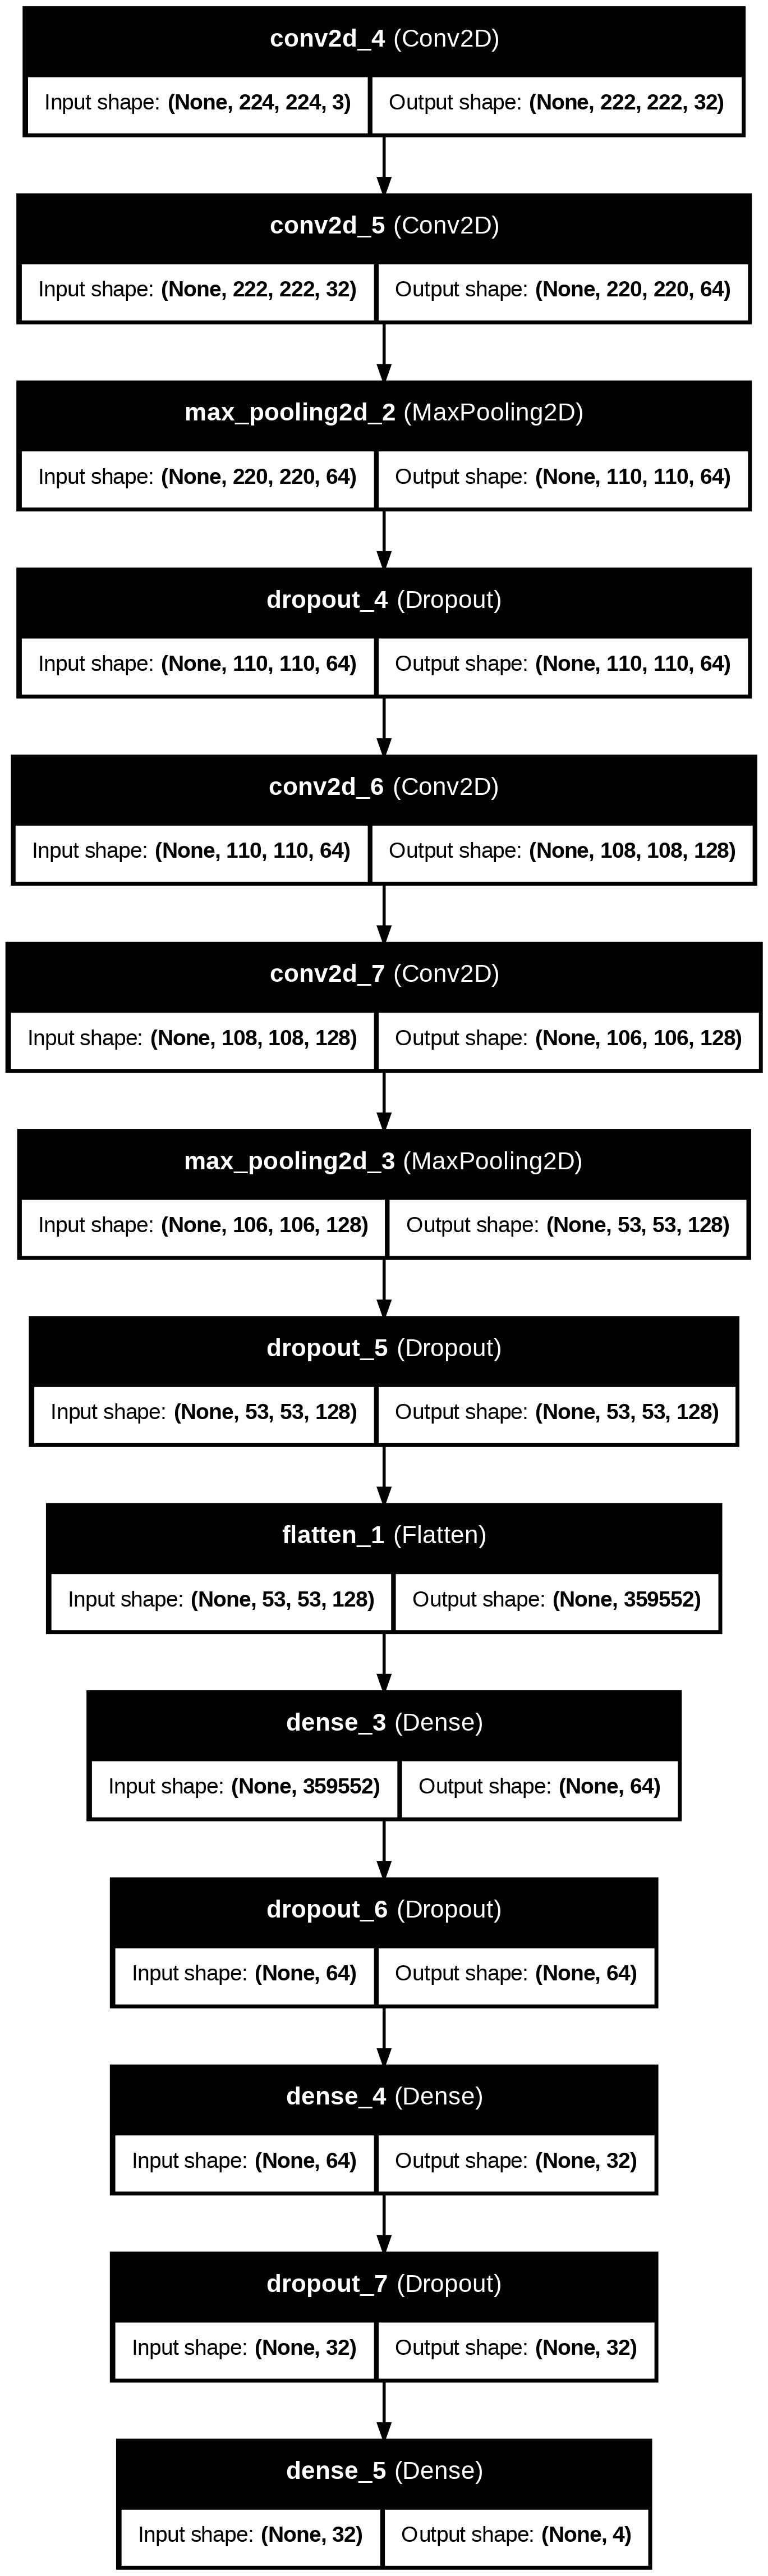

In [ ]:
plot_model(original_model, show_shapes=True, show_layer_names=True)

In [ ]:
test_loss, test_accuracy = original_model.evaluate(X_test_classification, Y_test_classification, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

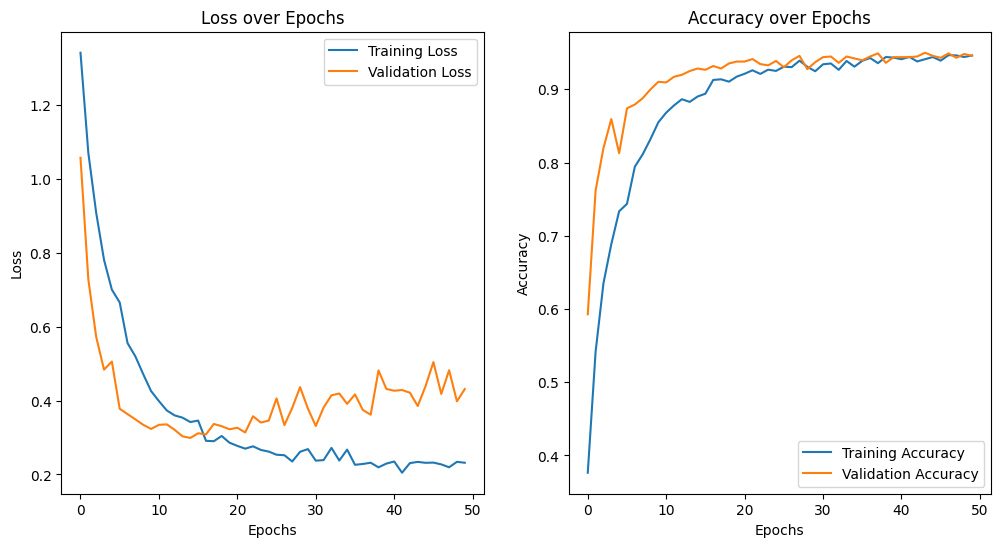

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       295
           1       0.96      0.98      0.97       271
           2       0.89      0.89      0.89       258
           3       0.96      0.99      0.97       335

    accuracy                           0.95      1159
   macro avg       0.94      0.94      0.94      1159
weighted avg       0.95      0.95      0.95      1159



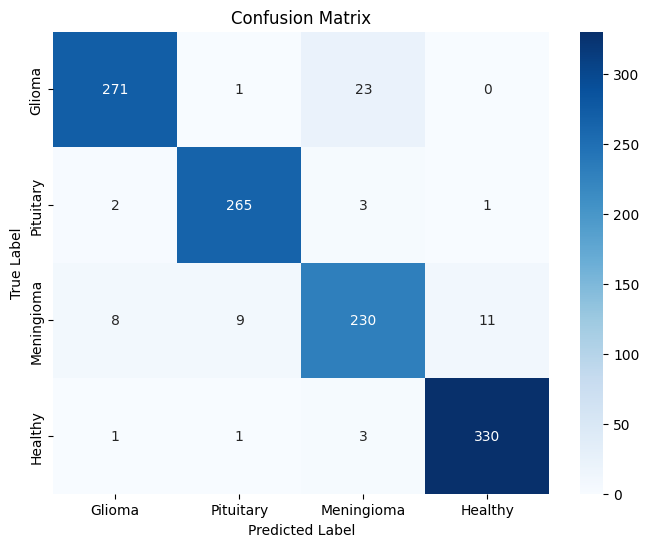

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(original_history.history['loss'], label='Training Loss')
plt.plot(original_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(original_history.history['accuracy'], label='Training Accuracy')
plt.plot(original_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
Y_val_classification_original_pred = original_model.predict(X_val_classification_final)
Y_val_original_classes = np.argmax(Y_val_classification_original_pred, axis=1)
Y_val_classification_original_true = np.argmax(Y_val_classification_final, axis=1)

# Generate classification report
report = classification_report(Y_val_classification_original_true, Y_val_original_classes, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
accuracy = report['accuracy']

print(classification_report(Y_val_classification_original_true, Y_val_original_classes))

# Confusion Matrix
cm = confusion_matrix(Y_val_classification_original_true, Y_val_original_classes)
plt.figure(figsize=(8, 6))
# labels = list(report.keys())[:-3]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_labels, yticklabels=image_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Split the data
X_train_classification_noise_reduction_final, X_val_classification_noise_reduction_final, Y_train_classification_noise_reduction_final, Y_val_classification_noise_reduction_final = train_test_split(X_train_classification_noise_reduction, Y_train_classification_encoded, test_size=0.2)

# Model
noise_reduction_baseline_model = Sequential()
noise_reduction_baseline_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
noise_reduction_baseline_model.add(Conv2D(64, (3, 3), activation='relu'))
noise_reduction_baseline_model.add(MaxPooling2D((2, 2)))
noise_reduction_baseline_model.add(Dropout(0.3))
noise_reduction_baseline_model.add(Conv2D(128, (3, 3), activation='relu'))
noise_reduction_baseline_model.add(Conv2D(128, (3, 3), activation='relu'))
noise_reduction_baseline_model.add(MaxPooling2D((2, 2)))
noise_reduction_baseline_model.add(Dropout(0.4))
noise_reduction_baseline_model.add(Flatten())
noise_reduction_baseline_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
noise_reduction_baseline_model.add(Dropout(0.5))
noise_reduction_baseline_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001)))
noise_reduction_baseline_model.add(Dropout(0.5))
noise_reduction_baseline_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
noise_reduction_baseline_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the baseline checkpoint path
noise_reduction_baseline_checkpoint_path = "/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/BaselineCNN_Weights/"

# Set up model checkpoint
noise_reduction_checkpoint_path_best = noise_reduction_baseline_checkpoint_path + "noise_reduction_model_best.keras"  # Best model based on validation loss

# Callbacks
noise_reduction_model_checkpoint_best = ModelCheckpoint(noise_reduction_checkpoint_path_best, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

noise_reduction_history = noise_reduction_baseline_model.fit( X_train_classification_noise_reduction_final, Y_train_classification_noise_reduction_final,
                                                              epochs=50,
                                                              batch_size=64,
                                                              validation_data=(X_val_classification_noise_reduction_final, Y_val_classification_noise_reduction_final),
                                                              callbacks=[noise_reduction_model_checkpoint_best])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.3213 - loss: 1.4841 - val_accuracy: 0.6644 - val_loss: 1.1109
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.4910 - loss: 1.1729 - val_accuracy: 0.7860 - val_loss: 0.7982
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6116 - loss: 0.9383 - val_accuracy: 0.7860 - val_loss: 0.7120
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6542 - loss: 0.8557 - val_accuracy: 0.7843 - val_loss: 0.5445
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6809 - loss: 0.7706 - val_accuracy: 0.8464 - val_loss: 0.5085
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7344 - loss: 0.6621 - val_accuracy: 0.8456 - val_loss: 0.4321
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7472 - loss: 0.6456 - val_accuracy: 0.8637 - val_loss: 0.4323
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7727 - loss: 0.5834 - val_accuracy: 0.8559 -

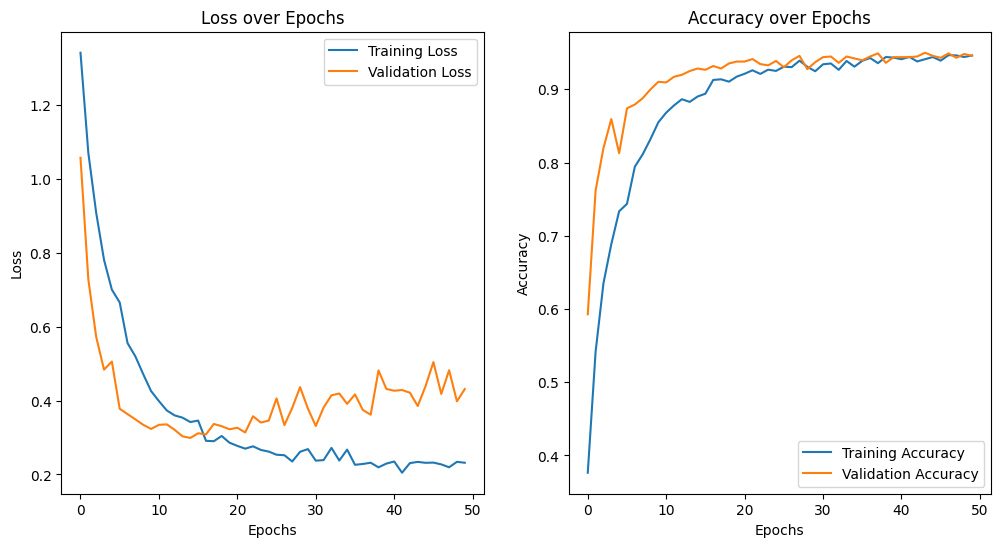

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       275
           1       0.92      0.96      0.94       297
           2       0.85      0.86      0.86       273
           3       0.97      0.97      0.97       314

    accuracy                           0.92      1159
   macro avg       0.92      0.92      0.92      1159
weighted avg       0.92      0.92      0.92      1159



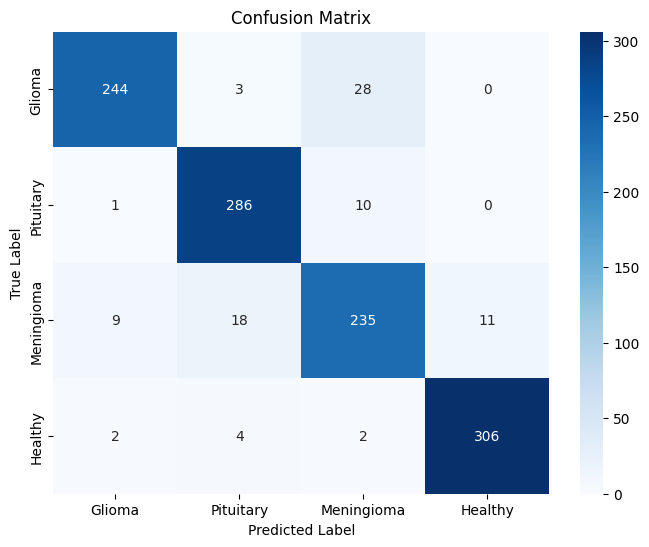

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
Y_val_classification_noise_reduction_pred = noise_reduction_baseline_model.predict(X_val_classification_noise_reduction_final)
Y_val_noise_reduction_classes = np.argmax(Y_val_classification_noise_reduction_pred, axis=1)
Y_val_classification_noise_reduction_true = np.argmax(Y_val_classification_noise_reduction_final, axis=1)

# Generate classification report
noise_reduction_report = classification_report(Y_val_classification_noise_reduction_true, Y_val_noise_reduction_classes, output_dict=True)
noise_reduction_precision = noise_reduction_report['weighted avg']['precision']
noise_reduction_recall = noise_reduction_report['weighted avg']['recall']
noise_reduction_f1_score = noise_reduction_report['weighted avg']['f1-score']
noise_reduction_accuracy = noise_reduction_report['accuracy']

print(classification_report(Y_val_classification_noise_reduction_true, Y_val_noise_reduction_classes))

# Confusion Matrix
cm = confusion_matrix(Y_val_classification_noise_reduction_true, Y_val_noise_reduction_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_labels, yticklabels=image_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Split the data
X_train_classification_constrast_enhancement_final, X_val_classification_constrast_enhancement_final, Y_train_classification_constrast_enhancement_final, Y_val_classification_constrast_enhancement_final = train_test_split(X_train_classification_contrast_enhancement, Y_train_classification_encoded, test_size=0.2)

# Model
constrast_enhancement_baseline_model = Sequential()
constrast_enhancement_baseline_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
constrast_enhancement_baseline_model.add(Conv2D(64, (3, 3), activation='relu'))
constrast_enhancement_baseline_model.add(MaxPooling2D((2, 2)))
constrast_enhancement_baseline_model.add(Dropout(0.3))
constrast_enhancement_baseline_model.add(Conv2D(128, (3, 3), activation='relu'))
constrast_enhancement_baseline_model.add(Conv2D(128, (3, 3), activation='relu'))
constrast_enhancement_baseline_model.add(MaxPooling2D((2, 2)))
constrast_enhancement_baseline_model.add(Dropout(0.4))
constrast_enhancement_baseline_model.add(Flatten())
constrast_enhancement_baseline_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
constrast_enhancement_baseline_model.add(Dropout(0.5))
constrast_enhancement_baseline_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001)))
constrast_enhancement_baseline_model.add(Dropout(0.5))
constrast_enhancement_baseline_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
constrast_enhancement_baseline_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the baseline checkpoint path
constrast_enhancement_baseline_checkpoint_path = "/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/BaselineCNN_Weights/"

# Set up model checkpoint
constrast_enhancement_checkpoint_path_best = constrast_enhancement_baseline_checkpoint_path + "constrast_enhancement_model_best.keras"  # Best model based on validation loss

# Callbacks
constrast_enhancement_model_checkpoint_best = ModelCheckpoint(constrast_enhancement_checkpoint_path_best, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

constrast_enhancement_history = constrast_enhancement_baseline_model.fit(   X_train_classification_constrast_enhancement_final, Y_train_classification_constrast_enhancement_final,
                                                                            epochs=50,
                                                                            batch_size=64,
                                                                            validation_data=(X_val_classification_constrast_enhancement_final, Y_val_classification_constrast_enhancement_final),
                                                                            callbacks=[constrast_enhancement_model_checkpoint_best])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.3178 - loss: 1.5463 - val_accuracy: 0.7843 - val_loss: 0.8415
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6008 - loss: 0.9748 - val_accuracy: 0.8663 - val_loss: 0.5050
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6968 - loss: 0.8173 - val_accuracy: 0.8663 - val_loss: 0.4391
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7598 - loss: 0.6736 - val_accuracy: 0.9034 - val_loss: 0.4069
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7733 - loss: 0.6237 - val_accuracy: 0.8973 - val_loss: 0.3174
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.8128 - loss: 0.5333 - val_accuracy: 0.9180 - val_loss: 0.3122
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8425 - loss: 0.4920 - val_accuracy: 0.9163 - val_loss: 0.2937
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.8375 - loss: 0.4651 - val_accuracy: 0.9206 -

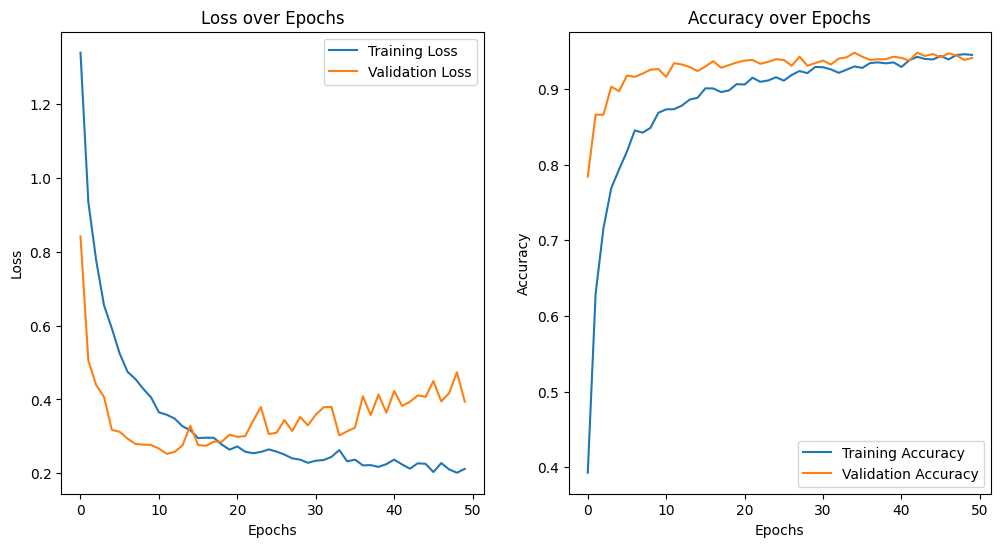

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       293
           1       0.96      0.97      0.96       296
           2       0.87      0.90      0.88       251
           3       0.97      0.97      0.97       319

    accuracy                           0.94      1159
   macro avg       0.94      0.94      0.94      1159
weighted avg       0.94      0.94      0.94      1159



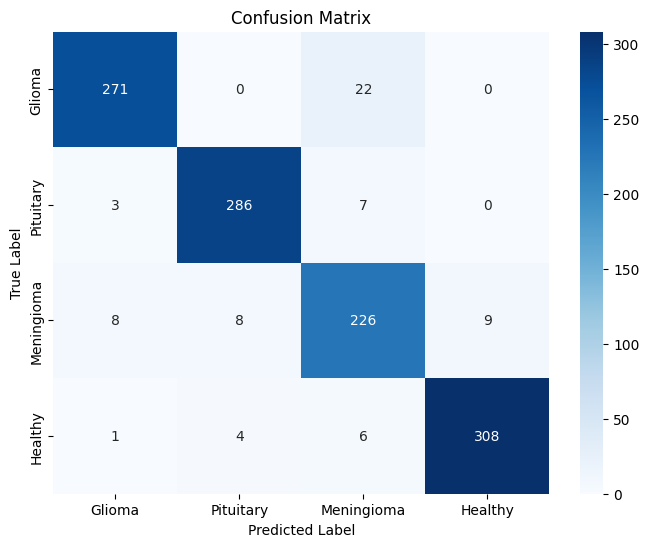

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(constrast_enhancement_history.history['loss'], label='Training Loss')
plt.plot(constrast_enhancement_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(constrast_enhancement_history.history['accuracy'], label='Training Accuracy')
plt.plot(constrast_enhancement_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
Y_val_classification_constrast_enhancement_pred = constrast_enhancement_baseline_model.predict(X_val_classification_constrast_enhancement_final)
Y_val_constrast_enhancement_classes = np.argmax(Y_val_classification_constrast_enhancement_pred, axis=1)
Y_val_classification_constrast_enhancement_true = np.argmax(Y_val_classification_constrast_enhancement_final, axis=1)

# Generate classification report
constrast_enhancement_report = classification_report(Y_val_classification_constrast_enhancement_true, Y_val_constrast_enhancement_classes, output_dict=True)
constrast_enhancement_precision = constrast_enhancement_report['weighted avg']['precision']
constrast_enhancement_recall = constrast_enhancement_report['weighted avg']['recall']
constrast_enhancement_f1_score = constrast_enhancement_report['weighted avg']['f1-score']
constrast_enhancement_accuracy = constrast_enhancement_report['accuracy']

print(classification_report(Y_val_classification_constrast_enhancement_true, Y_val_constrast_enhancement_classes))

# Confusion Matrix
cm = confusion_matrix(Y_val_classification_constrast_enhancement_true, Y_val_constrast_enhancement_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_labels, yticklabels=image_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Split the data
X_train_classification_stack_edge_final, X_val_classification_stack_edge_final, Y_train_classification_stack_edge_final, Y_val_classification_stack_edge_final = train_test_split(X_train_classification_contrast_enhancement, Y_train_classification_encoded, test_size=0.2)

# Model
stack_edge_baseline_model = Sequential()
stack_edge_baseline_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
stack_edge_baseline_model.add(Conv2D(64, (3, 3), activation='relu'))
stack_edge_baseline_model.add(MaxPooling2D((2, 2)))
stack_edge_baseline_model.add(Dropout(0.3))
stack_edge_baseline_model.add(Conv2D(128, (3, 3), activation='relu'))
stack_edge_baseline_model.add(Conv2D(128, (3, 3), activation='relu'))
stack_edge_baseline_model.add(MaxPooling2D((2, 2)))
stack_edge_baseline_model.add(Dropout(0.4))
stack_edge_baseline_model.add(Flatten())
stack_edge_baseline_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
stack_edge_baseline_model.add(Dropout(0.5))
stack_edge_baseline_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0001)))
stack_edge_baseline_model.add(Dropout(0.5))
stack_edge_baseline_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
stack_edge_baseline_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the baseline checkpoint path
stack_edge_baseline_checkpoint_path = "/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/BaselineCNN_Weights/"

# Set up model checkpoint
stack_edge_checkpoint_path_best = stack_edge_baseline_checkpoint_path + "stack_edge_model_best.keras"  # Best model based on validation loss

# Callbacks
stack_edge_model_checkpoint_best = ModelCheckpoint(stack_edge_checkpoint_path_best, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

stack_edge_history = stack_edge_baseline_model.fit( X_train_classification_stack_edge_final, Y_train_classification_stack_edge_final,
                                                    epochs=50,
                                                    batch_size=64,
                                                    validation_data=(X_val_classification_stack_edge_final, Y_val_classification_stack_edge_final),
                                                    callbacks=[stack_edge_model_checkpoint_best])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.2760 - loss: 2.2301 - val_accuracy: 0.6143 - val_loss: 1.2757
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4375 - loss: 1.2497 - val_accuracy: 0.8007 - val_loss: 0.9004
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5957 - loss: 1.0719 - val_accuracy: 0.8248 - val_loss: 0.7420
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6677 - loss: 0.9464 - val_accuracy: 0.8594 - val_loss: 0.6289
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7154 - loss: 0.8617 - val_accuracy: 0.8947 - val_loss: 0.5535
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7257 - loss: 0.8066 - val_accuracy: 0.8861 - val_loss: 0.4845
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7592 - loss: 0.7425 - val_accuracy: 0.9042 - val_loss: 0.4912
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7453 - loss: 0.7231 - val_accuracy: 0.8585 -

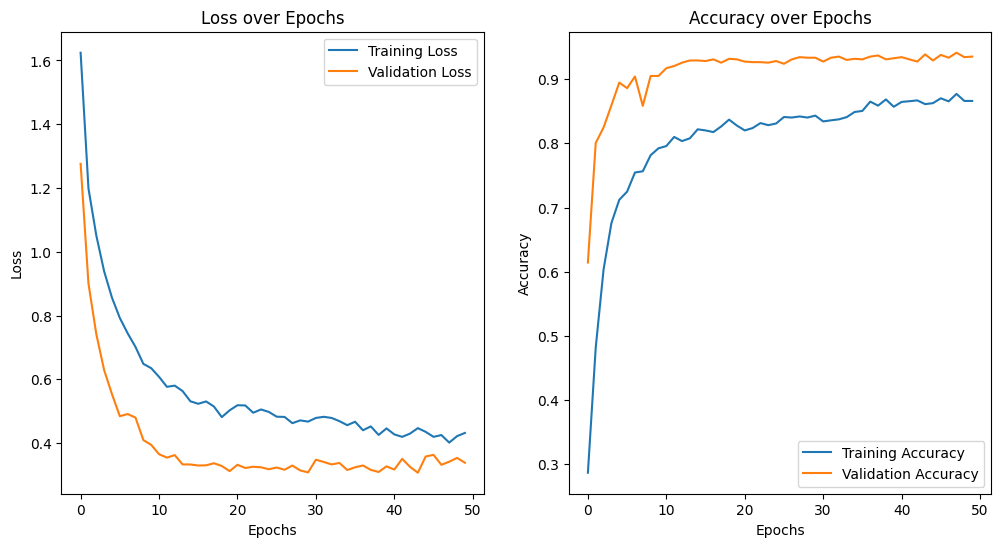

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.98      0.89      0.94       262
           1       0.94      0.95      0.95       297
           2       0.85      0.91      0.88       267
           3       0.97      0.97      0.97       333

    accuracy                           0.94      1159
   macro avg       0.94      0.93      0.93      1159
weighted avg       0.94      0.94      0.94      1159



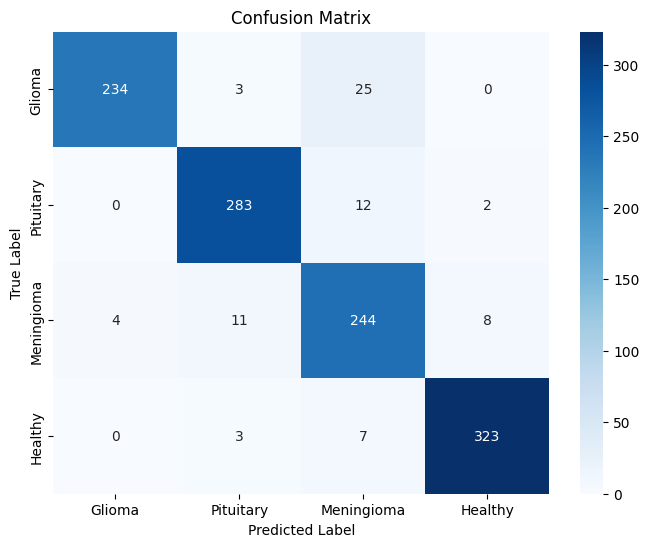

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(stack_edge_history.history['loss'], label='Training Loss')
plt.plot(stack_edge_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(stack_edge_history.history['accuracy'], label='Training Accuracy')
plt.plot(stack_edge_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
Y_val_classification_stack_edge_pred = stack_edge_baseline_model.predict(X_val_classification_stack_edge_final)
Y_val_stack_edge_classes = np.argmax(Y_val_classification_stack_edge_pred, axis=1)
Y_val_classification_stack_edge_true = np.argmax(Y_val_classification_stack_edge_final, axis=1)

# Generate classification report
stack_edge_report = classification_report(Y_val_classification_stack_edge_true, Y_val_stack_edge_classes, output_dict=True)
stack_edge_precision = report['weighted avg']['precision']
stack_edge_recall = report['weighted avg']['recall']
stack_edge_f1_score = report['weighted avg']['f1-score']
stack_edge_accuracy = report['accuracy']

print(classification_report(Y_val_classification_stack_edge_true, Y_val_stack_edge_classes))

# Confusion Matrix
cm = confusion_matrix(Y_val_classification_stack_edge_true, Y_val_stack_edge_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_labels, yticklabels=image_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### ResNet50 + CNN

***Done by Juin Tan***

In [ ]:
# Split the data
X_train_classification_final, X_val_classification_final, Y_train_classification_final, Y_val_classification_final = train_test_split(X_train_classification, Y_train_classification_encoded, test_size=0.2)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)   # Test
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
resnet_predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
resnet_model = Model(inputs=base_model.input, outputs=resnet_predictions)

# Compile the model
resnet_model.compile( optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Train the model
resnet_history = resnet_model.fit(
    X_train_classification_final,
    Y_train_classification_final,
    validation_data=(X_val_classification_final, Y_val_classification_final),
    epochs=50,
    batch_size=BATCH_SIZE
)

# Save the model
resnet_model.save("/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/resnet_cnn_model.h5")

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 337ms/step - accuracy: 0.2919 - loss: 1.3979 - val_accuracy: 0.4599 - val_loss: 1.2699
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4210 - loss: 1.2726 - val_accuracy: 0.5893 - val_loss: 1.1888
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4542 - loss: 1.1976 - val_accuracy: 0.4651 - val_loss: 1.1411
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5016 - loss: 1.1397 - val_accuracy: 0.5626 - val_loss: 1.0885
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5318 - loss: 1.0923 - val_accuracy: 0.6186 - val_loss: 1.0546
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5597 - loss: 1.0611 - val_accuracy: 0.6419 - val_loss: 1.0286
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6081 - loss: 1.0218 - val_accuracy: 0.6506 - val_loss: 1.0021
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6094 - loss: 0.9854 - val_accuracy: 0.6575 -

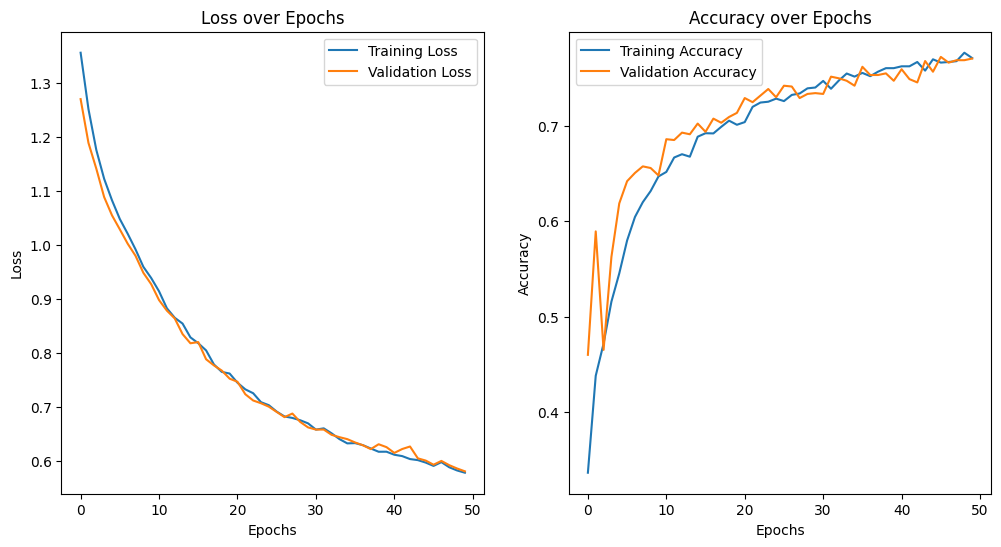

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       266
           1       0.82      0.89      0.85       288
           2       0.66      0.62      0.64       297
           3       0.89      0.88      0.89       308

    accuracy                           0.77      1159
   macro avg       0.77      0.77      0.77      1159
weighted avg       0.77      0.77      0.77      1159



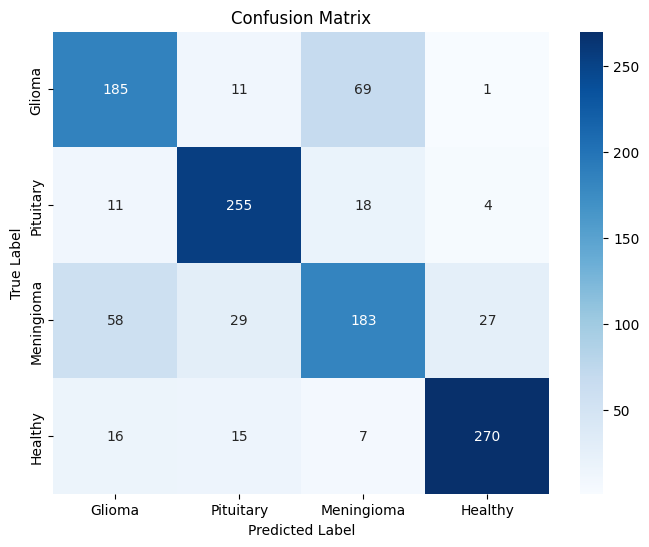

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
Y_val_classification_resnet_pred = resnet_model.predict(X_val_classification_final)
Y_val_resnet_classes = np.argmax(Y_val_classification_resnet_pred, axis=1)
Y_val_classification_resnet_true = np.argmax(Y_val_classification_final, axis=1)

# Generate classification report
resnet_report = classification_report(Y_val_classification_resnet_true, Y_val_resnet_classes, output_dict=True)
resnet_precision = resnet_report['weighted avg']['precision']
resnet_recall = resnet_report['weighted avg']['recall']
resnet_f1_score = resnet_report['weighted avg']['f1-score']
resnet_accuracy = resnet_report['accuracy']

print(classification_report(Y_val_classification_resnet_true, Y_val_resnet_classes))

# Confusion Matrix
cm = confusion_matrix(Y_val_classification_resnet_true, Y_val_resnet_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_labels, yticklabels=image_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Split the data
X_train_classification_stack_edge_final, X_val_classification_stack_edge_final, Y_train_classification_stack_edge_final, Y_val_classification_stack_edge_final = train_test_split(X_train_classification_contrast_enhancement, Y_train_classification_encoded, test_size=0.2)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)   # Test
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
resnet_predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
resnet_stack_edge_model = Model(inputs=base_model.input, outputs=resnet_predictions)

# Compile the model
resnet_stack_edge_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# Train the model
resnet_stack_edge_history = resnet_stack_edge_model.fit(
    X_train_classification_stack_edge_final,
    Y_train_classification_stack_edge_final,
    validation_data=(X_val_classification_stack_edge_final, Y_val_classification_stack_edge_final),
    epochs=50,
    batch_size=BATCH_SIZE
)

# Save the model
resnet_stack_edge_model.save("/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/resnet_stack_edge_cnn_model.h5")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 626ms/step - accuracy: 0.2674 - loss: 1.5369 - val_accuracy: 0.3520 - val_loss: 1.3170
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.3532 - loss: 1.3336 - val_accuracy: 0.4944 - val_loss: 1.2395
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.4117 - loss: 1.2672 - val_accuracy: 0.5487 - val_loss: 1.1748
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.4684 - loss: 1.2068 - val_accuracy: 0.5280 - val_loss: 1.1290
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.4943 - loss: 1.1583 - val_accuracy: 0.5712 - val_loss: 1.0771
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5216 - loss: 1.1129 - val_accuracy: 0.5884 - val_loss: 1.0283
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5450 - loss: 1.0657 - val_accuracy: 0.5988 - val_loss: 0.9940
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accur

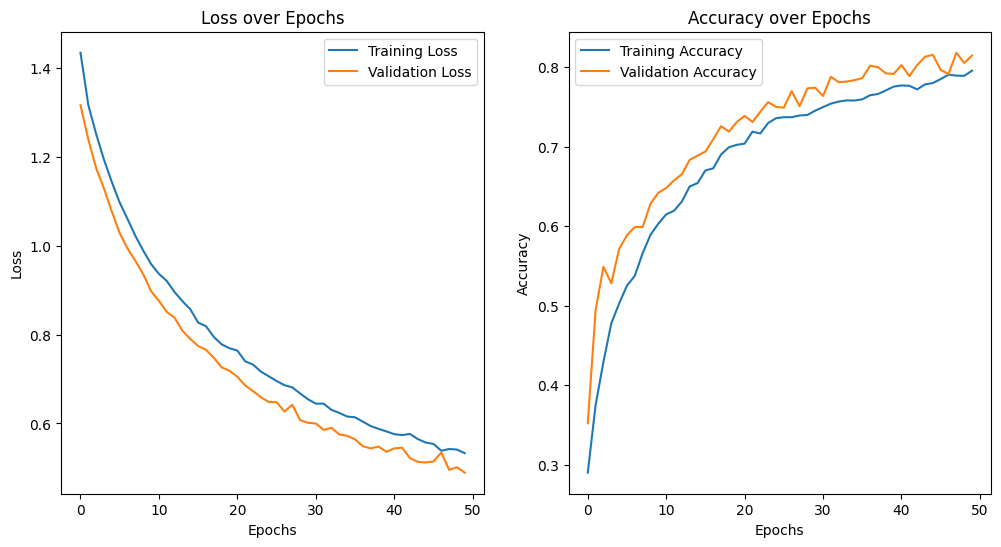

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       288
           1       0.85      0.91      0.88       296
           2       0.71      0.62      0.67       264
           3       0.96      0.89      0.92       311

    accuracy                           0.81      1159
   macro avg       0.81      0.81      0.81      1159
weighted avg       0.82      0.81      0.81      1159



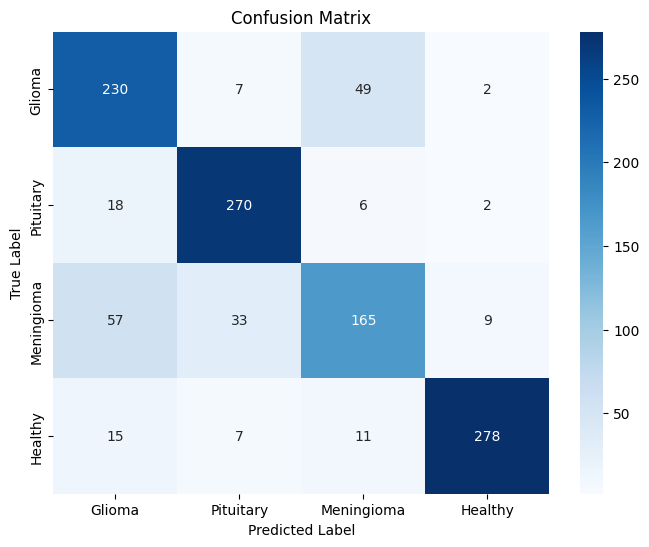

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(resnet_stack_edge_history.history['loss'], label='Training Loss')
plt.plot(resnet_stack_edge_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_stack_edge_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_stack_edge_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
Y_val_classification_resnet_stack_edge_pred = resnet_stack_edge_model.predict(X_val_classification_stack_edge_final)
Y_val_resnet_stack_edge_classes = np.argmax(Y_val_classification_resnet_stack_edge_pred, axis=1)
Y_val_classification_resnet_stack_edge_true = np.argmax(Y_val_classification_stack_edge_final, axis=1)

# Generate classification report
resnet_stack_edge_report = classification_report(Y_val_classification_resnet_stack_edge_true, Y_val_resnet_stack_edge_classes, output_dict=True)
resnet_stack_edge_precision = resnet_stack_edge_report['weighted avg']['precision']
resnet_stack_edge_recall = resnet_stack_edge_report['weighted avg']['recall']
resnet_stack_edge_f1_score = resnet_stack_edge_report['weighted avg']['f1-score']
resnet_stack_edge_accuracy = resnet_stack_edge_report['accuracy']

print(classification_report(Y_val_classification_resnet_stack_edge_true, Y_val_resnet_stack_edge_classes))

# Confusion Matrix
cm = confusion_matrix(Y_val_classification_resnet_stack_edge_true, Y_val_resnet_stack_edge_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_labels, yticklabels=image_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Vision Transformer (ViT)

***Done by Juin Tan***

In [ ]:
# Split the data
X_train_classification_final, X_val_classification_final, Y_train_classification_final, Y_val_classification_final = train_test_split(X_train_classification, Y_train_classification_encoded, test_size=0.2)

# Define the Vision Transformer model
class VisionTransformer(Model):
    def __init__(self, num_classes):
        super(VisionTransformer, self).__init__()
        self.patch_size = 16
        self.num_heads = 8
        self.d_model = 128  # Embedding size
        self.dff = 512      # Feed forward layer size
        self.num_layers = 4 # Number of transformer layers

        self.dense1 = Dense(self.d_model, activation='relu')
        self.attention_layers = [tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.d_model) for _ in range(self.num_layers)]
        self.global_pooling = GlobalAveragePooling1D()  # Changed to GlobalAveragePooling1D
        self.dense2 = Dense(num_classes, activation='softmax')

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Split the images into patches
        x = tf.image.extract_patches(images=x,
                                      sizes=[1, self.patch_size, self.patch_size, 1],
                                      strides=[1, self.patch_size, self.patch_size, 1],
                                      rates=[1, 1, 1, 1],
                                      padding='VALID')
        # Reshape to (batch_size, num_patches, patch_size * patch_size * channels)
        x = tf.reshape(x, (batch_size, -1, self.patch_size * self.patch_size * 3))

        # Apply dense layer to the patches
        x = self.dense1(x)

        # Apply multi-head attention layers
        for att_layer in self.attention_layers:
            x = att_layer(x, x)

        # Global average pooling to reduce dimensions to (batch_size, d_model)
        x = self.global_pooling(x)

        # Final dense layer for classification
        return self.dense2(x)


# Create the model
vit_model = VisionTransformer(num_classes)

# Compile the model
vit_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
vit_history = vit_model.fit(X_train_classification_final, Y_train_classification_final,
                    validation_data=(X_val_classification_final, Y_val_classification_final),
                    epochs=50,
                    batch_size=32)

# Save the model
vit_model.save("/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/vit_model.h5")

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.2922 - loss: 1.3396 - val_accuracy: 0.4513 - val_loss: 1.1110
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4973 - loss: 1.0775 - val_accuracy: 0.5893 - val_loss: 1.0255
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5973 - loss: 1.0089 - val_accuracy: 0.5815 - val_loss: 1.0333
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6070 - loss: 0.9973 - val_accuracy: 0.6083 - val_loss: 0.9913
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6434 - loss: 0.9428 - val_accuracy: 0.6204 - val_loss: 1.0218
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6470 - loss: 0.9269 - val_accuracy: 0.6652 - val_loss: 0.9168
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6672 - loss: 0.8696 - val_accuracy: 0.7023 - val_loss: 0.8721
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6666 - loss: 0.8549 - val_acc

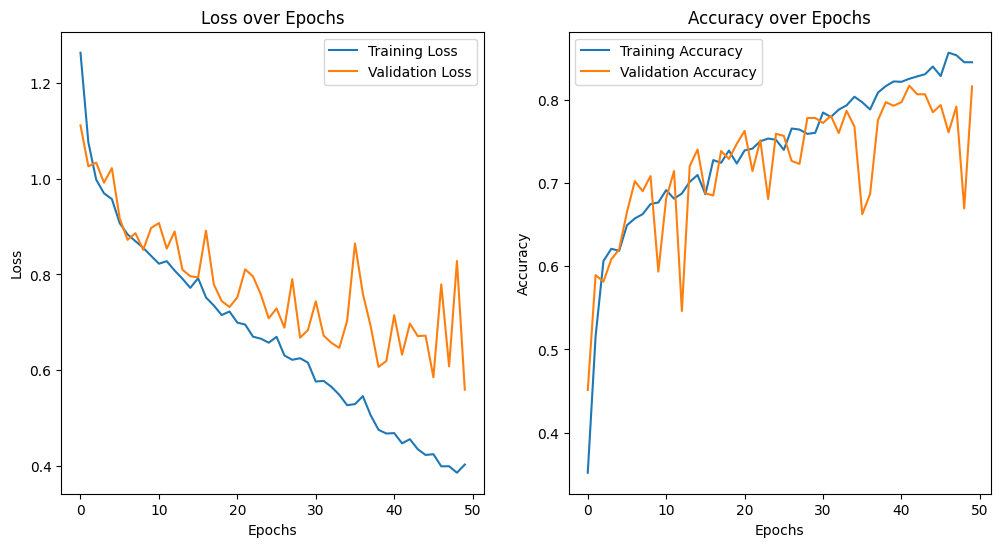

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       276
           1       0.87      0.84      0.85       296
           2       0.68      0.69      0.69       287
           3       0.88      0.95      0.92       300

    accuracy                           0.82      1159
   macro avg       0.82      0.81      0.81      1159
weighted avg       0.82      0.82      0.82      1159



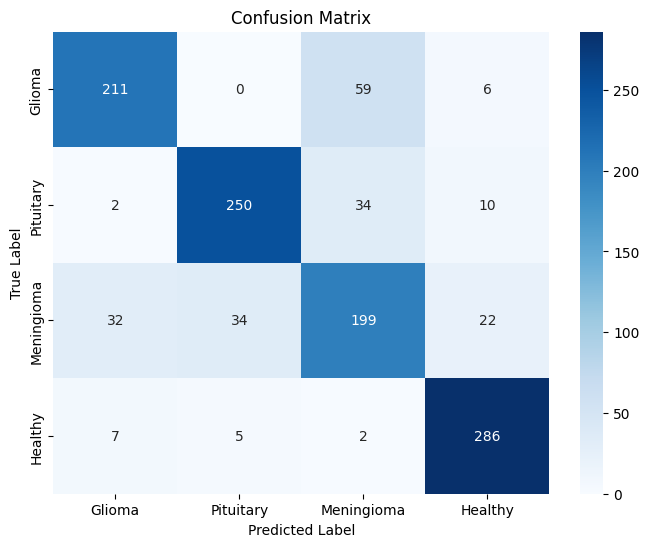

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
Y_val_classification_vit_pred = vit_model.predict(X_val_classification_final)
Y_val_vit_classes = np.argmax(Y_val_classification_vit_pred, axis=1)
Y_val_classification_vit_true = np.argmax(Y_val_classification_final, axis=1)

# Generate classification report
vit_report = classification_report(Y_val_classification_vit_true, Y_val_vit_classes, output_dict=True)
vit_precision = vit_report['weighted avg']['precision']
vit_recall = vit_report['weighted avg']['recall']
vit_f1_score = vit_report['weighted avg']['f1-score']
vit_accuracy = vit_report['accuracy']

print(classification_report(Y_val_classification_vit_true, Y_val_vit_classes))

# Confusion Matrix
cm = confusion_matrix(Y_val_classification_vit_true, Y_val_vit_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_labels, yticklabels=image_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Split the data
X_train_classification_stack_edge_final, X_val_classification_stack_edge_final, Y_train_classification_stack_edge_final, Y_val_classification_stack_edge_final = train_test_split(X_train_classification_contrast_enhancement, Y_train_classification_encoded, test_size=0.2)

# Define the Vision Transformer model
class VisionTransformer(Model):
    def __init__(self, num_classes):
        super(VisionTransformer, self).__init__()
        self.patch_size = 16
        self.num_heads = 8
        self.d_model = 128  # Embedding size
        self.dff = 512      # Feed forward layer size
        self.num_layers = 4 # Number of transformer layers

        self.dense1 = Dense(self.d_model, activation='relu')
        self.attention_layers = [tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.d_model) for _ in range(self.num_layers)]
        self.global_pooling = GlobalAveragePooling1D()  # Changed to GlobalAveragePooling1D
        self.dense2 = Dense(num_classes, activation='softmax')

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Split the images into patches
        x = tf.image.extract_patches(images=x,
                                      sizes=[1, self.patch_size, self.patch_size, 1],
                                      strides=[1, self.patch_size, self.patch_size, 1],
                                      rates=[1, 1, 1, 1],
                                      padding='VALID')
        # Reshape to (batch_size, num_patches, patch_size * patch_size * channels)
        x = tf.reshape(x, (batch_size, -1, self.patch_size * self.patch_size * 3))

        # Apply dense layer to the patches
        x = self.dense1(x)

        # Apply multi-head attention layers
        for att_layer in self.attention_layers:
            x = att_layer(x, x)

        # Global average pooling to reduce dimensions to (batch_size, d_model)
        x = self.global_pooling(x)

        # Final dense layer for classification
        return self.dense2(x)


# Create the model
vit_stack_edge_model = VisionTransformer(num_classes)

# Compile the model
vit_stack_edge_model.compile( optimizer=Adam(learning_rate=LEARNING_RATE),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Train the model
vit_stack_edge_history = vit_stack_edge_model.fit(X_train_classification_stack_edge_final, Y_train_classification_stack_edge_final,
                                                  validation_data=(X_val_classification_stack_edge_final, Y_val_classification_stack_edge_final),
                                                  epochs=50,
                                                  batch_size=32)

# Save the model
vit_stack_edge_model.save("/content/drive/My Drive/COMP4211_Project/ClassificationModel_Weights/vit_stack_edge_model.h5")

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.2589 - loss: 1.3860 - val_accuracy: 0.3244 - val_loss: 1.3779
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3254 - loss: 1.2956 - val_accuracy: 0.3978 - val_loss: 1.0708
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4742 - loss: 1.0706 - val_accuracy: 0.4271 - val_loss: 1.1903
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4967 - loss: 1.0514 - val_accuracy: 0.5531 - val_loss: 0.9997
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5533 - loss: 0.9729 - val_accuracy: 0.4996 - val_loss: 1.0458
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5826 - loss: 0.9436 - val_accuracy: 0.4659 - val_loss: 1.1413
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5850 - loss: 0.9268 - val_accuracy: 0.5686 - val_loss: 0.9636
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6032 - loss: 0.9118 - val_acc

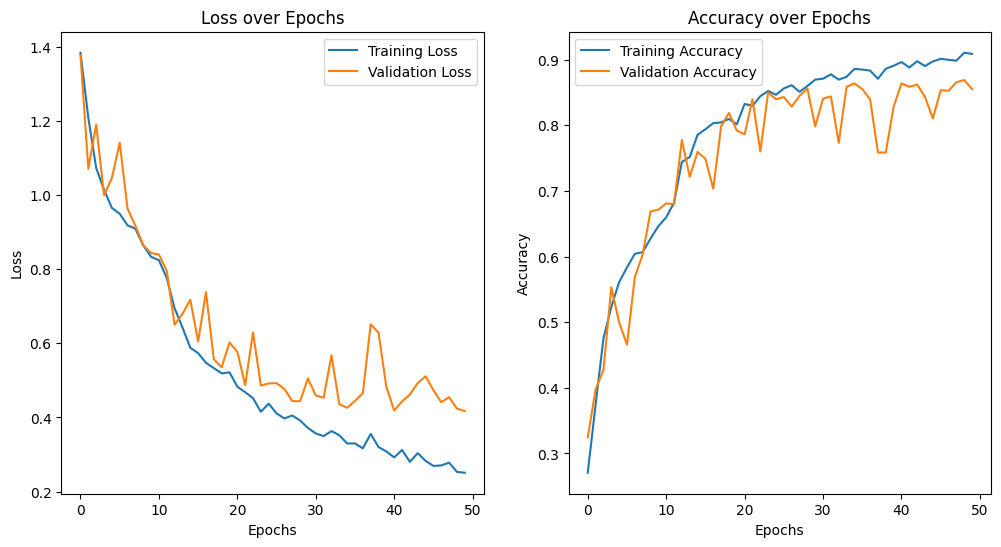

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       258
           1       0.90      0.90      0.90       290
           2       0.72      0.72      0.72       263
           3       0.96      0.91      0.94       348

    accuracy                           0.86      1159
   macro avg       0.85      0.85      0.85      1159
weighted avg       0.86      0.86      0.86      1159



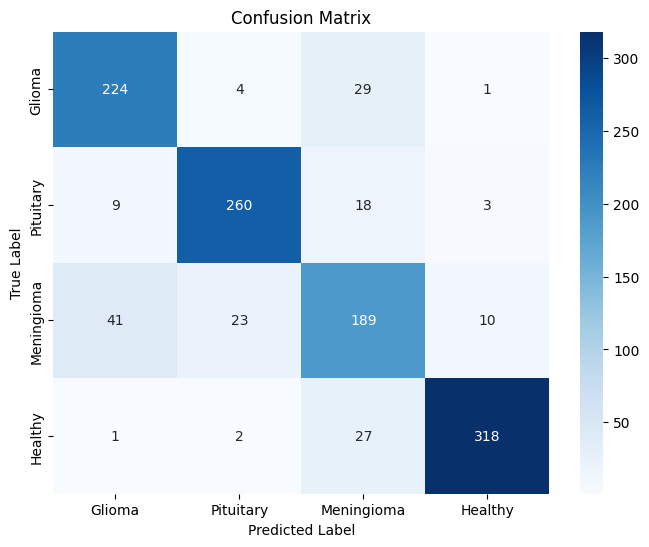

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(vit_stack_edge_history.history['loss'], label='Training Loss')
plt.plot(vit_stack_edge_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vit_stack_edge_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_stack_edge_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
Y_val_classification_vit_stack_edge_pred = vit_stack_edge_model.predict(X_val_classification_stack_edge_final)
Y_val_vit_stack_edge_classes = np.argmax(Y_val_classification_vit_stack_edge_pred, axis=1)
Y_val_classification_vit_stack_edge_true = np.argmax(Y_val_classification_stack_edge_final, axis=1)

# Generate classification report
vit_stack_edge_report = classification_report(Y_val_classification_vit_stack_edge_true, Y_val_vit_stack_edge_classes, output_dict=True)
vit_stack_edge_precision = vit_stack_edge_report['weighted avg']['precision']
vit_stack_edge_recall = vit_stack_edge_report['weighted avg']['recall']
vit_stack_edge_f1_score = vit_stack_edge_report['weighted avg']['f1-score']
vit_stack_edge_accuracy = vit_stack_edge_report['accuracy']

print(classification_report(Y_val_classification_vit_stack_edge_true, Y_val_vit_stack_edge_classes))

# Confusion Matrix
cm = confusion_matrix(Y_val_classification_vit_stack_edge_true, Y_val_vit_stack_edge_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=image_labels, yticklabels=image_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Machine Learning Task 2: Brain MRI Segmentation Model

***Done by Henry Wijaya***

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define dataset folder path
ZIP_FILE_PATH = '/content/drive/My Drive/brain_coco.zip'  # Change this to your zip file path
EXTRACTED_FOLDER_PATH = '/content/dataset'  # Folder to extract files to
!unzip -q "$ZIP_FILE_PATH" -d "$EXTRACTED_FOLDER_PATH"

In [ ]:
def create_mask(image_shape, category, segmentation):
    mask = np.zeros((image_shape[0], image_shape[1], 4), dtype=np.uint8)
    if segmentation == None:
        return mask
    # Define colors for each tumor category (BGR format)
    colors = {
        1: (0, 1, 0, 0),  # Green for Glioma Tumor
        2: (1, 0, 0, 0),  # Blue for Meningioma Tumor
        4: (0, 0, 1, 0),  # Red for Pituitary Tumor
    }
    if category not in colors:
        return mask
    polygon = []
    segmentation = segmentation[0]
    for i in range(0, len(segmentation), 2):
        x = int(segmentation[i])  # Scale x
        y = int(segmentation[i + 1])  # Scale y
        polygon.append([x, y])

    # Convert to a numpy array and fill the polygon
    polygon = np.array([polygon], dtype=np.int32)  # Shape needs to be (1, n, 2)
    cv2.fillPoly(mask, polygon, colors[category])
    return mask

def load_annotations(annotation_file):
    with open(annotation_file) as f:
        data = json.load(f)
    return data['images'], data['annotations']

def load_segmentation_data(base_path, images, annotations):
    image_dict = {image['id']: image['file_name'] for image in images}
    ret_img = []
    ret_mask = []
    for annotation in annotations:
        category_id = annotation['category_id']
        img_id = annotation['image_id']
        img_path = image_dict[img_id]
        img = cv2.imread(os.path.join(base_path, img_path))
        # Resize the image to the target size
        if 'segmentation' in annotation:
            segmentation = annotation['segmentation']
            mask = create_mask(img.shape, category_id, segmentation)
        else:
            mask = create_mask(img.shape, category_id, None)
        img = cv2.resize(img, (128, 128))
        ret_img.append(img)
        mask = cv2.resize(mask, (128, 128))
        ret_mask.append(mask)
    return np.array(ret_img), np.array(ret_mask)

# Define the dataset directories
base_dir = '/content/dataset'  # Update this to your dataset path
datasets = ['train', 'valid', 'test']

# Initialize variables for images and masks
train_images, train_masks = None, None
valid_images, valid_masks = None, None
test_images, test_masks = None, None

for dataset in datasets:
    images_dir = os.path.join(base_dir, dataset)
    annotation_file = os.path.join(base_dir, dataset, '_annotations.coco.json')

    # Load annotations from the JSON file
    images, annotations = load_annotations(annotation_file)
    images_data, masks_data = load_segmentation_data(images_dir, images, annotations)

    # Assign to the appropriate variable
    if dataset == 'train':
        train_images, train_masks = images_data, masks_data
    elif dataset == 'valid':
        valid_images, valid_masks = images_data, masks_data
    elif dataset == 'test':
        test_images, test_masks = images_data, masks_data

# Output the shapes of the datasets
print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Validation Images Shape:", valid_images.shape)
print("Validation Masks Shape:", valid_masks.shape)
print("Test Images Shape:", test_images.shape)
print("Test Masks Shape:", test_masks.shape)

In [ ]:
# Define U-Net model
NUM_CLASSES = 3
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Contracting path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    # Expansive path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    outputs = layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(128, 128, 3), classes=4, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same', use_bias=False,
                   name='Conv' if input_shape[2] == 3 else 'Conv_')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4_shape = tf.keras.backend.int_shape(b4)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Reshape((1, 1, b4_shape[1]))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before[1:3], interpolation="bilinear"
        )(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        skip_size = tf.keras.backend.int_shape(skip1)
        x = tf.keras.layers.experimental.preprocessing.Resizing(
                *skip_size[1:3], interpolation="bilinear"
            )(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before3[1:3], interpolation="bilinear"
        )(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')

In [ ]:
# Instantiate the model
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice Loss.

    Parameters:
    - y_true: Ground truth labels (shape: batch_size, height, width, channels)
    - y_pred: Predicted labels (shape: batch_size, height, width, channels)
    - smooth: Smoothing factor to avoid division by zero

    Returns:
    - Dice Loss value
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
# unet_training_model = unet_model((IMG_HEIGHT, IMG_WIDTH, CHANNELS))
# unet_training_model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])
deeplab_model = Deeplabv3()
deeplab_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
# Train the model
# unet_training_history = unet_training_model.fit(train_images, train_masks, validation_data=(valid_images, valid_masks), epochs=5, batch_size=16)
deeplab_history = deeplab_model.fit(train_images, train_masks, validation_data=(valid_images, valid_masks), epochs=1, batch_size=16)

In [ ]:
# Predict on test dataset
deeplab_predictions = deeplab_model.predict(test_images[:20])
deeplab_predictions = np.argmax(deeplab_predictions, axis=-1)

# Calculate accuracy
deeplab_test_accuracy = np.mean(np.equal(np.argmax(test_masks[:20], axis=-1), deeplab_predictions))
print(f'Test Accuracy: {deeplab_test_accuracy * 100:.2f}%')

# Visualize predictions
def visualize_predictions(test_images, predictions, test_masks):
    num_images = min(len(test_images), 20)  # Display up to 5 images
    plt.figure(figsize=(15, num_images * 2))

    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(test_images[i], cmap='gray')
        plt.title('Test Image')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(test_masks[i, :, :, :-1] * 255)  # Use colormap for visualization
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i])  # Use colormap for visualization
        plt.title('Predicted Mask')
        plt.axis('off')

        """
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(test_images[i], cmap='gray')
        plt.imshow(predictions[i], cmap='jet', alpha=0.5)  # Overlay prediction
        plt.title('Overlay')
        plt.axis('off')
        """
    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_predictions(test_images, deeplab_predictions, test_masks)

## Generate Report

***Done by Juin Tan***

In [ ]:
# To generate report where get inputs from the clinicians and the predictions from the models

def generate_patient_report(patient_name, patient_image_path, segmentation_image_path, output_filename, image_labels):
    # Load and preprocess the patient's MRI image
    img = cv2.imread(patient_image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0                   # Normalize the image
    img = np.expand_dims(img, axis=0)   # Add batch dimension

    # Predict using the classification model
    classification_prediction_result = original_model.predict(img)
    classification_prediction_patient = np.argmax(classification_prediction_result)

    # Predict using the segmentation model
    # This part is currently hardcoded because the segmentation model has not been done and properly trained
    # segmentation_result_to_normal_result = [-1, 0, 2, -1, 1]

    # segmentation_prediction_result_raw = unet_training_model.predict(img)
    # segmentation_predicted_mask = np.argmax(segmentation_prediction_result_raw, axis=-1)
    # unique, counts = np.unique(segmentation_predicted_mask, return_counts=True)
    # segmentation_prediction_patient_raw = unique[np.argmax(counts)]
    # segmentation_prediction_patient = segmentation_result_to_normal_result[segmentation_prediction_patient_raw]
    segmentation_prediction_result = classification_prediction_result
    segmentation_prediction_patient = classification_prediction_patient

    # [IF WANT TO GENERATE REPORT WITH BOTH MODELS OUTPUT THE SAME PREDICTION]
    # classification_prediction_patient = 0
    # segmentation_prediction_patient = 0
    # [IF WANT TO GENERATE REPORT WITH TWO MODELS OUTPUT THE DIFFERENT PREDICTIONS]
    # classification_prediction_patient = 0
    # segmentation_prediction_patient = 1

    # Prepare prediction message
    prediction_message = ""
    if classification_prediction_patient == segmentation_prediction_patient:
        prediction_message = "* This prediction result has a high confidence level. However, it is always advisable to consult with a qualified medical professional for a comprehensive evaluation."
    else:
        prediction_message = "* The prediction results are inconsistent. It is important to consult a qualified medical professional for a thorough evaluation and diagnosis to confirm the findings."

    # Determine the final prediction result
    # if classification_prediction_result[0][classification_prediction_patient] >= segmentation_prediction_result[0][segmentation_prediction_patient]:
    #     prediction_result = classification_prediction_patient
    # else:
    #     prediction_result = segmentation_prediction_patient

    # Since classfication model has a much higher accuracy in our project and is more reliable, if both models have different predictions,
    # the final predicted label will be the classfication model's prediction
    prediction_result = classification_prediction_patient

    prediction_result_label = image_labels[prediction_result]
    if prediction_result_label != "Healthy":
        prediction_result_label += " Tumor"

    # Generate PDF report
    pdf = FPDF()
    pdf.add_page()

    # Set title
    pdf.set_font("Times", 'B', 20)
    pdf.cell(0, 10, 'Brain Tumor Prediction Report', ln=True, align='C')
    pdf.ln(10)  # Add a line break

    # Add patient name
    pdf.set_font("Times", '', 14)
    pdf.cell(0, 10, f'Patient Name: {patient_name}', ln=True)
    pdf.ln(5)  # Add a line break

    # Add prediction result
    pdf.cell(0, 10, f'Prediction Result: {prediction_result_label}', ln=True)
    pdf.ln(5)  # Add a line break

    # Add confidence note
    pdf.set_font("Times", 'BI', 14)
    pdf.multi_cell(0, 10, prediction_message)  # Use multi_cell for wrapping text
    pdf.ln(10)  # Add a line break

    # Add patient's MRI image
    pdf.set_font("Times", '', 12)
    pdf.cell(0, 10, "Patient's MRI Image:", ln=True)
    pdf.image(patient_image_path, x=10, y=pdf.get_y(), w=60)  # Adjust w to fit the page
    pdf.ln(70)  # Add space after the image

    # Add tumor segmentation image
    pdf.cell(0, 10, "Predicted Diagnosis MRI Image:", ln=True)
    pdf.image(segmentation_image_path, x=10, y=pdf.get_y(), w=60)  # Adjust w to fit the page
    pdf.ln(80)  # Add space after the image

    # Add footer
    pdf.set_font("Times", 'I', 10)  # Set font to italic, size 10
    pdf.cell(0, 10, 'Prepared by Juin Tan', 0, 0, 'C')  # Centered footer

    # Save the PDF
    pdf.output(output_filename)

# Example usage
patient_name = "CHAN Tai Man"
patient_image_path = "/content/drive/My Drive/COMP4211_Project/Generated_Report/Successful/patient_image.jpg"
segmentation_image_path = "/content/drive/My Drive/COMP4211_Project/Generated_Report/Successful/patient_segmentation_image.jpg"
output_filename = "Brain_Tumor_Prediction_Report_Successful.pdf"

generate_patient_report(patient_name, patient_image_path, segmentation_image_path, output_filename, image_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
